# HLAthena
### A Python package for HLA class I peptide analysis, binding prediction, and model training

## Table of Contents
1. [Installation](#installation)
2. [Usage](#usage)
    - [Importing the package](#importing)
    - [Single Peptide Set Analysis](#singlepepanalysis)
    - [Peptide Set Annotation](#pepannotation)
    - [Gene Set Enrichment Analysis](#gsea)
    - [Peptide Set Comparison Analysis](#multipepanalysis)
    - [Binding Prediction](#predict)

<a name="installation"></a>
## Installation

To install hlathena run: 

    git clone https://github.com/ssarkizova/hlathenav2
    cd hlathenav2
    pip install .


<a name="usage"></a>
## Usage
<a name="importing"></a>
### Importing the package

In [1]:
import hlathena as ha

#### Loading data

Next, we'll import some example data. We are using a file with A0101 eluted ligand binders of length 8-12 with a few additional columns.

In [2]:
import pandas as pd
import os

data_dir = 'input/'
sample_pep_file = 'A0101_filtered.txt'

df = pd.read_table(os.path.join(data_dir, sample_pep_file))

#### Peptide Dataset Class

We can now create an object of `hlathena`'s PeptideDataset class. Alternatively, a PeptideDataset can be created with a simple list of peptides.

In [3]:
peptide_dataset = ha.PeptideDataset(df, pep_col_name='seq', allele_col_name='allele')

The PeptideDataset will maintain any additional columns. We can view the full dataframe by accessing it's `pep_df` attribute:

In [4]:
peptide_dataset.pep_df.head()

,ha__allele,ha__pep,ha__pep_len,allele,length,seq,score,backbone_cleav,totalIntensity,hg19.kgXref.geneSymbol
0,A0101,ADMGHLKY,8,A0101,8,ADMGHLKY,16.74,7,23600000.0,PCNA
1,A0101,ELDDTLKY,8,A0101,8,ELDDTLKY,9.66,6,30300000.0,PPP2CA
2,A0101,FSDNIEFY,8,A0101,8,FSDNIEFY,8.51,6,950000.0,NUP107
3,A0101,FTELAILY,8,A0101,8,FTELAILY,8.76,6,39900000.0,CLTC
4,A0101,GLDEPLLK,8,A0101,8,GLDEPLLK,9.22,6,31400000.0,HLA-DQA2


### Single Peptide Set Analysis <a name="singlepepanalysis"></a>

Now that our data is loaded, we can create some plots to understand it's composition and characteristics.

First, we'll plot the length distribution of the peptide set.

#### Plot length

<AxesSubplot:title={'center':'Length distribution (n=1383)'}>

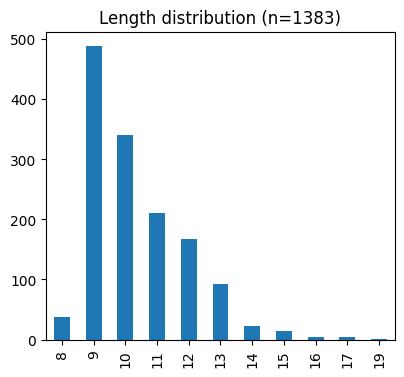

In [5]:
ha.plot_length(peptide_dataset.pep_df)

Next, we'll visualize the amino acid motifs of this peptide set

#### Plot logo

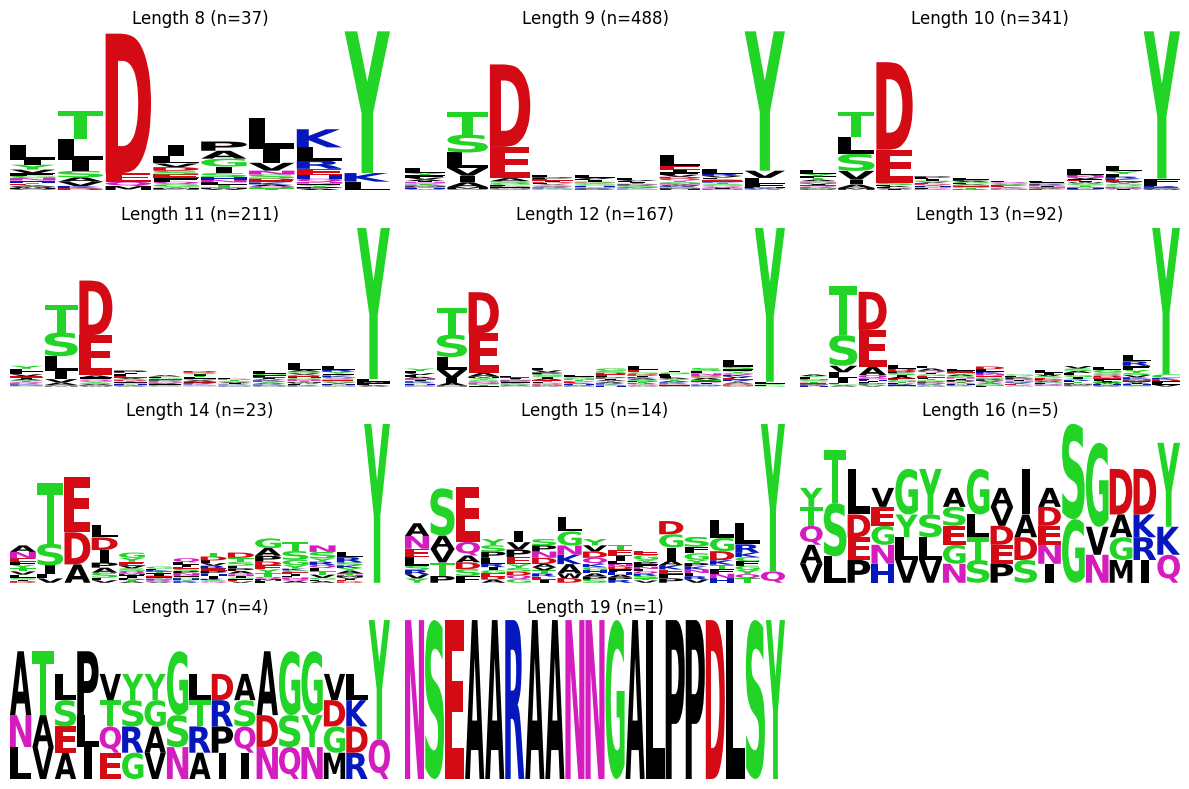

In [15]:
_ = ha.plot_logo(peptide_dataset.pep_df) # saving to dummy variable for tidier output

We can also select a particle length to plot by providing a length parameter. Let's examine the 9mer's motif more closely:

[<AxesSubplot:title={'center':'Length 9 (n=488)'}>]

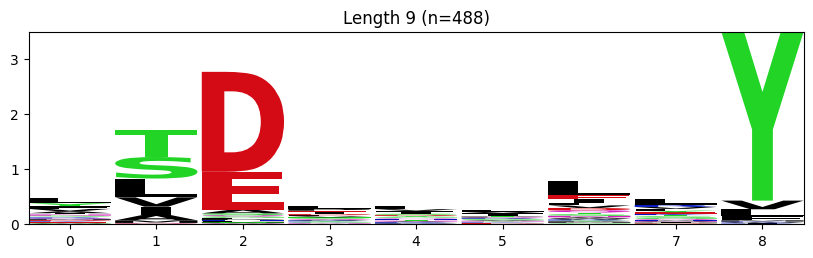

In [14]:
ha.plot_logo(peptide_dataset.pep_df, length=9)

#### PCA Encoding

Next, we want to cluster these peptides and visualize them in 2D. First, we need to do numerically encode the peptides so that we can project them in lower dimensional space. We can do this using with peptide projection module. First, we use principal component analysis (PCA) to encode the peptide sequences.

We can PCA encode the peptides in 3 different ways:
1. Using the default encoding (Kidera Factors)
2. Using a custom amino acid feature matrix
3. Using built-in amino acid feature matrices

Alternatively, this encoding can be pre-computed and loaded in using the `precomp_PCA_path` parameter or saved for future use using the `save_PCA_path` parameter.

1. Using the default encoding

In this case we don't have to specify the `aa_feature_map` parameter. Merely pass in the peptide list and peptide length. In this case, we will also specify the allele (A0101) which will weight the positions based on the pre-determined motif entropies for this allele.

In [9]:
feature_matrix_default = ha.PCA_encode(
    peptide_dataset.get_peptides(),     
    9, 
    allele = 'A0101', 
    save_PCA_path = 'pca_encoding.npz')

2. Using a custom amino acid feature matrix

By providing a path (or list of paths) to an amino acid feature matrix (any 20 x N space-delimited file), the user can customize the feature encoding. In this example, we demonstrate this by providing a path to a Kidera Factors feature matrix.

In [10]:
aa_feature_files = [os.path.join(data_dir, 'aafeatmat_KideraFactors.txt')]
aa_feature_map = ha.AminoAcidFeatureMap(aa_feature_files=aa_feature_files)

feature_matrix = ha.PCA_encode(
    peptide_dataset.get_peptides(),     
    9, 
    allele = 'A0101', 
    aa_feature_map = aa_feature_map,
    save_PCA_path = 'pca_encoding.npz')

3. Using built-in amino acid feature matrices

The user can select among the built-in amino acid feature matrices. These include:
* Kidera Factors
* BLOSUM62
* PMBEC
* PCs

In [11]:
feature_matrix_builtin = ha.PCA_encode(
    peptide_dataset.get_peptides(),     
    9, 
    allele = 'A0101', 
    aa_feature_map = ha.AminoAcidFeatureMap(
        aa_feature_files=[ha.definitions.aa_feature_file_PCA3, 
                          ha.definitions.aa_feature_file_BLOSUM]),
    save_PCA_path = 'pca_encoding.npz')

#### UMAP Embedding & Plot

Now we can create a UMAP embedding using any of these encodings and plot it, e.g.

<AxesSubplot:title={'center':'A0101 9-mers'}, xlabel='umap_1', ylabel='umap_2'>

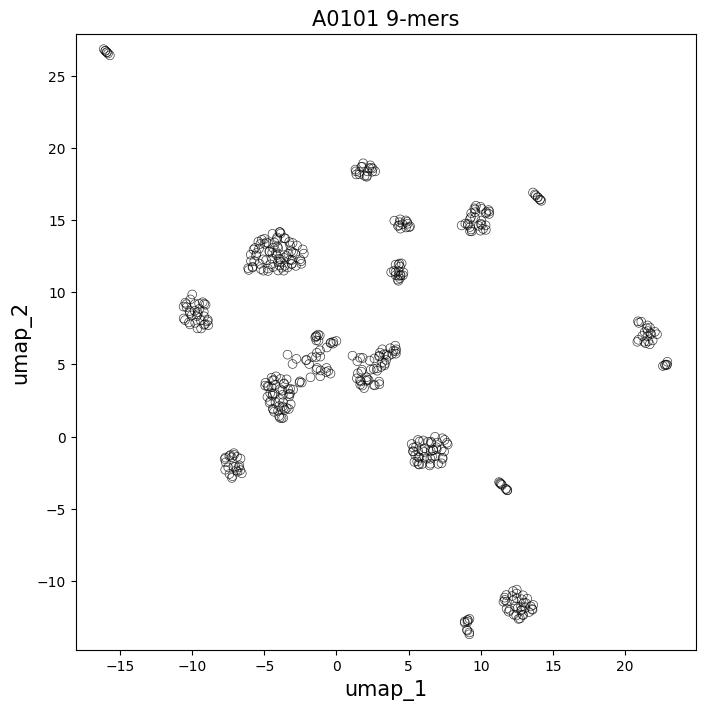

In [12]:
umap_embedding = ha.get_umap_embedding(feature_matrix_default)  # embedding with default Kidera Factors
# umap_embedding = ha.get_umap_embedding(feature_matrix)  # embedding with custom file (also Kidera Factors in this case)
# umap_embedding = ha.get_umap_embedding(feature_matrix_builtin)  # embedding with built-in features

ax = ha.plot_umap(umap_embedding, title='A0101 9-mers')

#### Clustered UMAP

Finally, we can cluster these peptides into groups based on motif similarity using a density based clustering (DBSCAN):

In [16]:
peptide_clustering = ha.get_peptide_clustering(
    umap_embedding,
    eps = 1)

peptide_clustering.head()

,pep,umap_1,umap_2,cluster
0,AADIFYSRY,-7.712566,-2.3014,7
1,AADLNLVLY,-7.502692,-2.137139,7
2,AADLVEALY,-7.008338,-2.088799,7
3,AIDEDVLRY,9.337475,15.483001,6
4,AIDLLKEIY,9.602146,15.166716,6


(<AxesSubplot:xlabel='umap_1', ylabel='umap_2'>,
 <AxesSubplot:xlabel='count', ylabel='cluster'>)

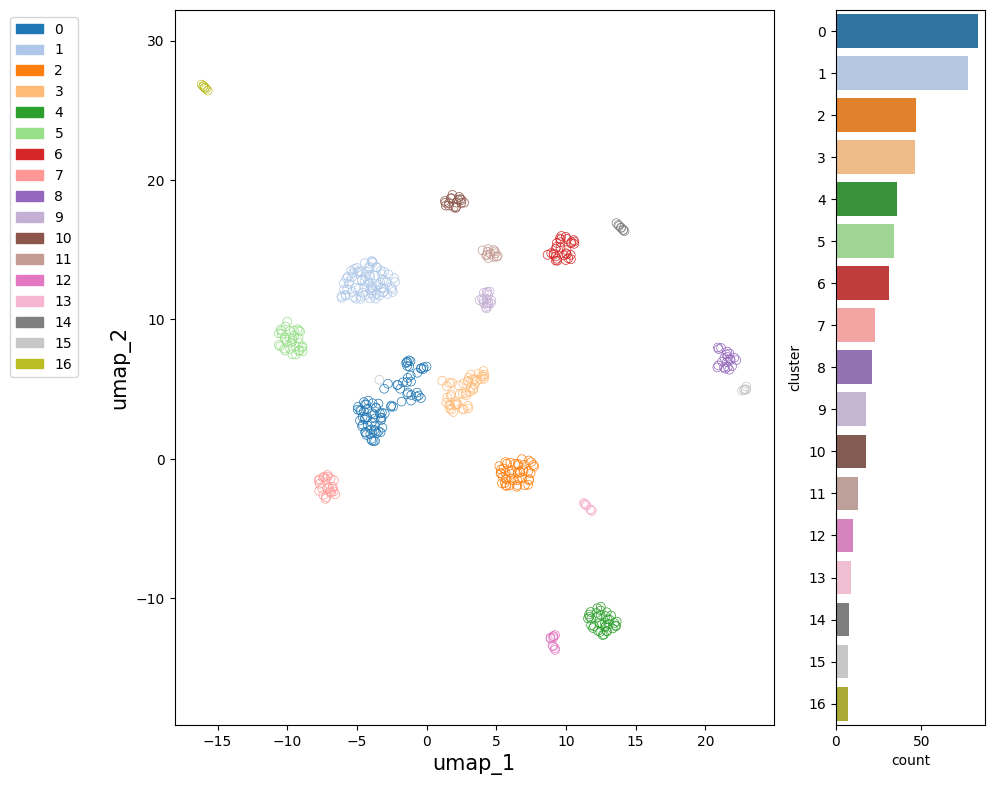

In [17]:
ha.plot_umap(
    peptide_clustering, 
    clustered=True,
)

To understand the composition of these clusters, we can plot using an additional label column. To do this, we will merge the new clustered dataframe with the original dataframe.

In [18]:
df.columns = ['allele', 'length', 'pep', 'score', 'backbone_cleav', 'totalIntensity',
       'hg19.kgXref.geneSymbol']
merged = peptide_clustering.merge(df, on='pep')

#### Labeled UMAP

By providing a dataframe and specifying the `label_col` parameter, the user can analyze the cluster composition across any categorical label. In this case, we annotate with the backbone cleavage score.

(<AxesSubplot:xlabel='umap_1', ylabel='umap_2'>,
 <AxesSubplot:xlabel='count', ylabel='cluster'>)

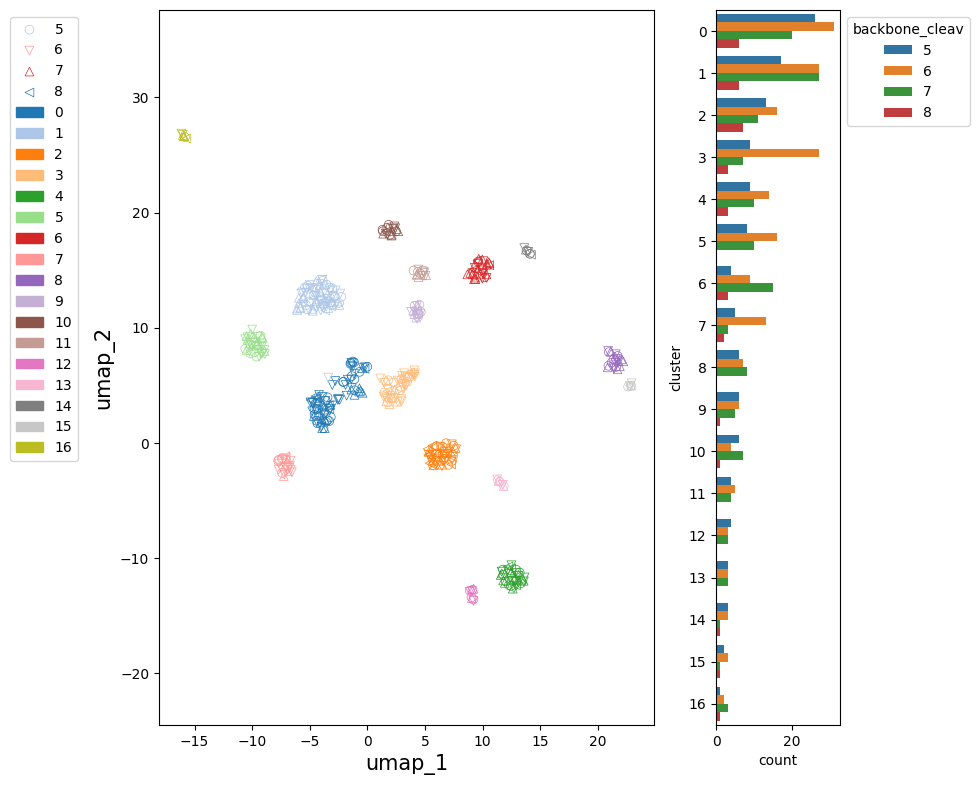

In [19]:
ha.plot_umap(
    merged, 
    clustered=True, 
    label_col='backbone_cleav')

### Peptide Set Annotation <a name="pepannotation"></a>

In Sarkizova et al., we found that additional endogenous variables provided substantial improvements in accurate peptide-HLA binding prediction. Specifically, cleavability and gene expression enhanced prediction efficacy. In the past, these improvements could be difficult to capitalize on if a user did not happen to have this data available for their peptide queries. In order to make these improvement models more accessible, we include support for Hugo Symbol, flanking sequence, and reference gene expression annotation.

#### Gene symbol and context sequence lookup

We use `get_reference_gene_ids` to locate which gene(s) a peptide sequence is in. By setting the `add_context` parameter to `True` we can also add the 30 amino acids upstream and downstream of the query peptide. By default, we use the hg19 proteome as a reference but a custom reference FASTA file path can be provided to the `ref_fasta` parameter.

Note: this may take a few minutes for very large datasets.

In [20]:
annotated_peptides = ha.get_reference_gene_ids(peptide_dataset, add_context=True)
annotated_peptides.pep_df.head()

,ha__pep,ha__pep_len,pep,Hugo_Symbol,ctex_up,ctex_dn
0,YSDVAKGILQY,11,YSDVAKGILQY,SPATA20,HVPHFEKMLYDQAQLAVAYSQAFQLSGDEF,VARSLSHRSGGFYSAEDADSPPERGQRPKE
1,HIDFGGTSVWY,11,HIDFGGTSVWY,KDM7A,ENYWPDDSVFPKPFVQKYCLMGVQDSYTDF,HVLWGEKIFYLIKPTDENLARYESWSSSVT
2,YLETVAAYY,9,YLETVAAYY,IL32,PKVLSDDMKKLKARMVMSSLAELEDDFKEG,EEQHPELTPLLEKERDGLRCRGNRSPVPDV
3,LSELFMSSFQSY,12,LSELFMSSFQSY,IL32,GVLAWVKEKVVALVHAVQALWKQFQSFCCS,GAPRGDKEELTPQKCSEPQSSK--------
4,HSEFLTVPAGSY,12,HSEFLTVPAGSY,HIVEP2,LSHSSSFSMSFEREETSKLSALPKQDEFGK,SLSVPGHHHQKEMRRCSSEQMPCPHPAEVP


#### Gene expression lookup in reference database(s)

Next, we can annotate with TCGA reference data. In order to determine which options are available and/or the TCGA cancer type abbreviation, we call the ```list_expression_references()``` function. In this case, we will annotate with reference breast cancer expression data. 

Note: this is demo functionality with support for The Cancer Genome Atlas' (TCGA) reference RNA expression datasets. We plan to expand support to additional references in future updates, including Cancer Cell Line Encyclopedia (CCLE), GenoType Expression Portal (GTeX), and the Human Protein Atlas (HPA).

In [21]:
ha.list_tcga_expression_references().head()

,Study Name
Study Abbreviation,
LAML,Acute Myeloid Leukemia
ACC,Adrenocortical carcinoma
BLCA,Bladder Urothelial Carcinoma
LGG,Brain Lower Grade Glioma
BRCA,Breast invasive carcinoma


 The user can identify the cancer type of interest and provide it as a parameter to `add_tcga_expression`. In this case, we will annotate with median breast cancer expression values.

In [22]:
annotated_peptides = ha.add_tcga_expression(annotated_peptides, 'BRCA')

Ta da! Now we have everything we need to incorporate the peptides' cleavability and expression data into our binding prediction scores.

In [23]:
annotated_peptides.pep_df.head()

,ha__pep,ha__pep_len,pep,Hugo_Symbol,ctex_up,ctex_dn,BRCA_TPM
0,YSDVAKGILQY,11,YSDVAKGILQY,SPATA20,HVPHFEKMLYDQAQLAVAYSQAFQLSGDEF,VARSLSHRSGGFYSAEDADSPPERGQRPKE,60.573
1,YSDVAKGILQY,11,YSDVAKGILQY,SPATA20,----------XQAQLAVAYSQAFQLSGDEF,VARSLSHRSGGFYSAEDADSPPERGQRPKE,60.573
2,HIDFGGTSVWY,11,HIDFGGTSVWY,KDM7A,ENYWPDDSVFPKPFVQKYCLMGVQDSYTDF,HVLWGEKIFYLIKPTDENLARYESWSSSVT,10.569
3,YLETVAAYY,9,YLETVAAYY,IL32,PKVLSDDMKKLKARMVMSSLAELEDDFKEG,EEQHPELTPLLEKERDGLRCRGNRSPVPDV,90.279
4,LSELFMSSFQSY,12,LSELFMSSFQSY,IL32,GVLAWVKEKVVALVHAVQALWKQFQSFCCS,GAPRGDKEELTPQKCSEPQSSK--------,90.279


### Gene Set Enrichment Analysis <a name="gsea"></a>

#### Using gene annotation for gene set enrichment analysis

In addition to binding prediction, our gene annotation feature enables us to explore whether any proteins or pathways may be differentially presented on HLA using the external GSEApy library.

Using the data from Sarkizova et al. (Supp. Data 6), we compare a Glioblastoma (GBM) patient's tumor cell line with and without IFNy stimulation to examine the impact of inflammation on the processing of HLA-bound ligands. 


In [24]:
# !pip install gseapy  # install GSEApy if it is not installed
import gseapy as gp

To perform gene set enrichment analysis on these peptide sets, we load the two samples and then annotate with their gene origin. 


In [25]:
IFNy_samples = pd.read_excel(os.path.join(data_dir, 'IFNy_sample_data/41587_2019_322_MOESM10_ESM - NBT 2019 Supp6.xlsx'), usecols=['Clinical ID','Type','Length','Peptide'])
GBM = IFNy_samples.loc[IFNy_samples['Clinical ID']=='H4198-BT187']
GBM_IFN = IFNy_samples.loc[IFNy_samples['Clinical ID']=='H4198-BT187_IFN']



In [26]:
GBM_genes = ha.get_reference_gene_ids(GBM, pep_col_name='Peptide', add_context=False).pep_df
GBM_IFN_genes = ha.get_reference_gene_ids(GBM_IFN, pep_col_name='Peptide', add_context=False).pep_df

Next, we use `enrichr` to examine over- and underrepresented pathways.

In [27]:
GSEA_GBM = gp.enrichr(gene_list=list(GBM_genes['Hugo_Symbol']), gene_sets=['MSigDB_Hallmark_2020'], outdir='GBM_GSEA_results')
GSEA_GBM_IFN = gp.enrichr(gene_list=list(GBM_IFN_genes['Hugo_Symbol']), gene_sets=['MSigDB_Hallmark_2020'], outdir='GBM_IFN_GSEA_results')

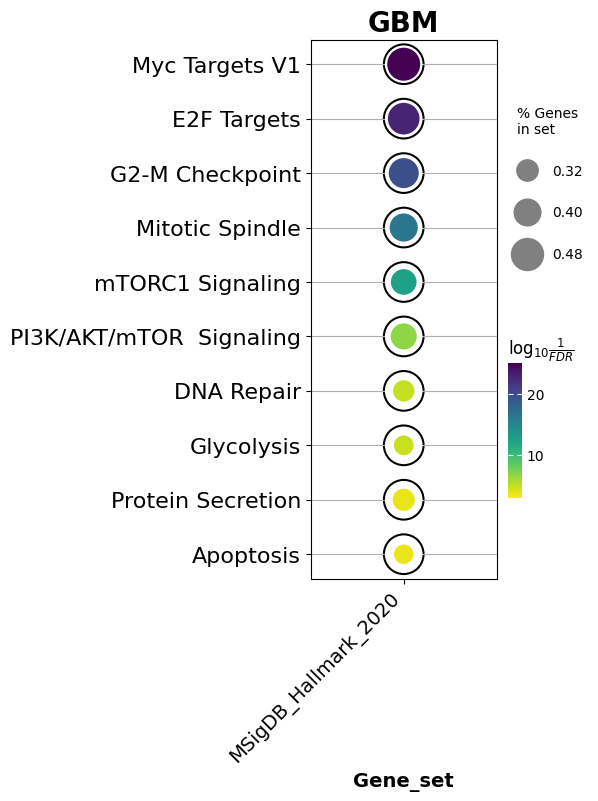

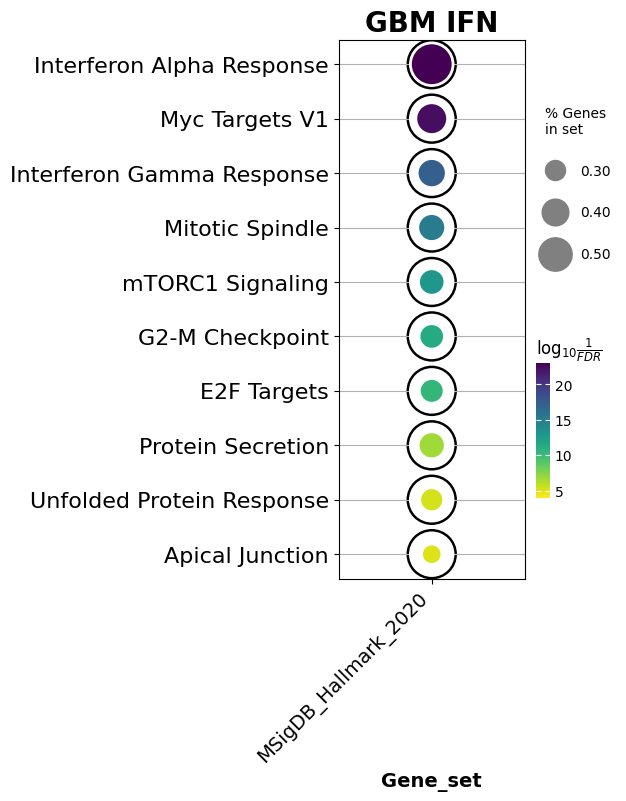

In [28]:
from gseapy import dotplot

ax2 = dotplot(GSEA_GBM.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=8,
              top_term=10,
              figsize=(3,7),
              title = "GBM",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o'
             )

ax1 = dotplot(GSEA_GBM_IFN.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=8,
              top_term=10,
              figsize=(3,7),
              title = "GBM IFN",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o'              
             )



As expected, we can see upregulation in the inflammation pathway genes in the sample stimulated with IFNy.

### Peptide Set Comparison Analysis <a name="multipepanalysis"></a>

Next, we can use the plotting module to characterize any differences that may exist between these two sets of presented peptides. After concatenating the two peptide sets into a labeled PeptideDataset, we will plot the length distributions and sequence motifs.

In [29]:
# --------------------------------------
# NOTE: If you'd like to play around further, you can try comparing a different sample available in the dataset
# IFNy_samples['Clinical ID'].unique() # list available sample options
# sample_id = '13240-005' # change this to explore other samples
# GBM = IFNy_samples.loc[IFNy_samples['Clinical ID']==sample_id]  # subset to selected sample
# GBM_IFN = IFNy_samples.loc[IFNy_samples['Clinical ID']==f'{sample_id}_IFN']  # subset to selected sample
# ---------------------------------------

GBM.loc[:,'label'] = 'GBM'
GBM_IFN.loc[:,'label'] = 'GBM_with_IFN'
GBM_peptide_dataset = ha.PeptideDataset(pd.concat([GBM,GBM_IFN]), pep_col_name='Peptide', reset_index=True)
GBM_peptide_dataset.pep_df

/Users/cleoforman/PycharmProjects/hlathenav2/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,ha__pep,ha__pep_len,Clinical ID,Type,Length,Peptide,label
0,AAAAAQSVY,9,H4198-BT187,GBM,9,AAAAAQSVY,GBM
1,AAAAPRAVA,9,H4198-BT187,GBM,9,AAAAPRAVA,GBM
2,AAAAPSPVM,9,H4198-BT187,GBM,9,AAAAPSPVM,GBM
3,AAADASPSL,9,H4198-BT187,GBM,9,AAADASPSL,GBM
4,AAADVLEAL,9,H4198-BT187,GBM,9,AAADVLEAL,GBM
...,...,...,...,...,...,...,...
8230,YTDSSYEEKKY,11,H4198-BT187_IFN,GBM,11,YTDSSYEEKKY,GBM_with_IFN
8231,YTERDASGMLY,11,H4198-BT187_IFN,GBM,11,YTERDASGMLY,GBM_with_IFN
8232,YTERDGSAMVY,11,H4198-BT187_IFN,GBM,11,YTERDGSAMVY,GBM_with_IFN
8233,YVIDQGETDVY,11,H4198-BT187_IFN,GBM,11,YVIDQGETDVY,GBM_with_IFN


To make a UMAP comparison, we'll need to select a particular length. We can once again use the ```plot_length``` function to find the length distribution of the combined dataset.

<AxesSubplot:xlabel='length', ylabel='count'>

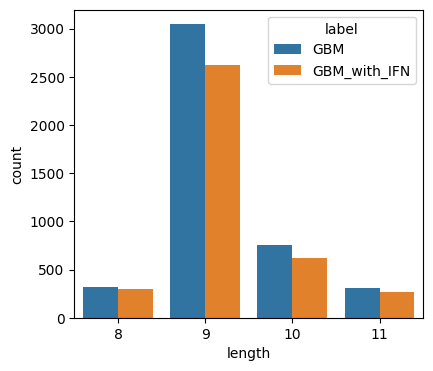

In [30]:
ha.plot_length(GBM_peptide_dataset.pep_df, label_col='label')

For each length, we can plot the two group's motifs side-by-side. For the most part, the sequence motifs between these 2 samples look very similar. This is in-line with prior findings. However, it appears there may be some difference in the 8-mer sub-anchor at position 5.

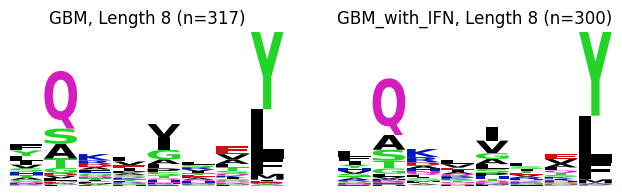

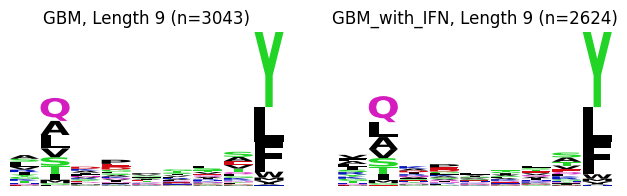

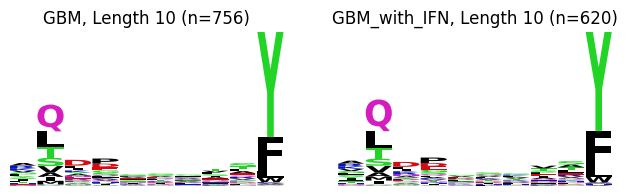

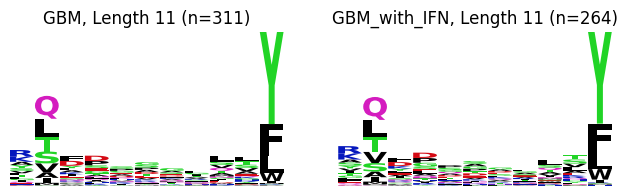

In [34]:
for len in GBM_peptide_dataset.get_peptide_lengths():
    ha.plot_logo(GBM_peptide_dataset.pep_df, length=len, label_col='label')

As we did in the single peptide set analysis, we will generate a feature matrix using PCA encode. This is a multi-allelic sample, so we won't specify the HLA.

In [35]:
GBM_feature_matrix = ha.PCA_encode(
    GBM_peptide_dataset.get_peptides(),     
    8,
    aa_feature_map = ha.AminoAcidFeatureMap(aa_feature_files=[
                          ha.definitions.aa_feature_file_Kidera,
                          ha.definitions.aa_feature_file_BLOSUM
        ]),
    save_PCA_path = 'pca_encoding_IFNsamples.npz',
)

umap_embedding = ha.get_umap_embedding(GBM_feature_matrix)

umap_embedding.head()


,pep,umap_1,umap_2
0,AAAWPLLL,17.636179,-6.12174
1,ADDSVRSL,8.477709,0.664082
2,ADMGHLKY,7.491926,-5.824144
3,AEGFVRAL,8.431319,0.51333
4,ANKLITVY,-2.10188,-7.099949


<AxesSubplot:title={'center':'GBM with IFNy vs. GBM Presented Peptides'}, xlabel='umap_1', ylabel='umap_2'>

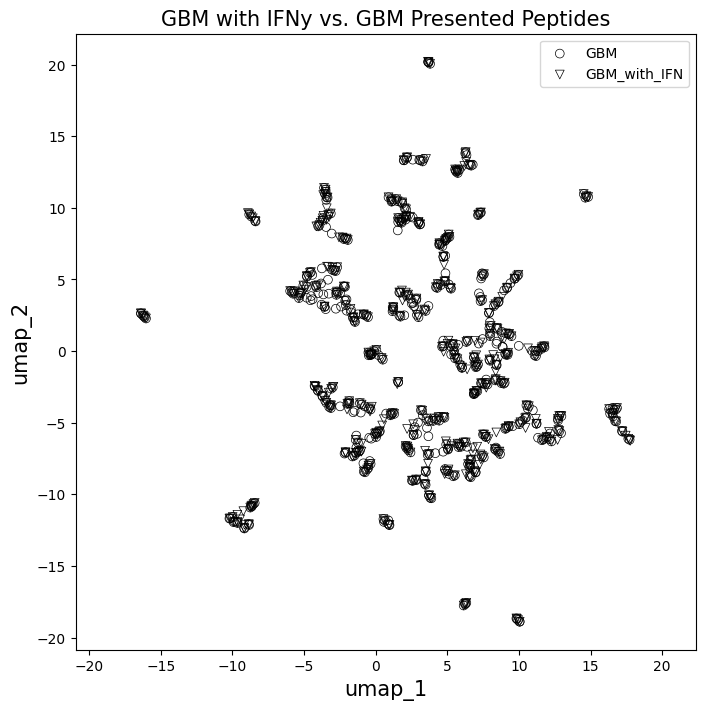

In [36]:
umap_embedding.rename(columns={'pep': 'ha__pep'}, inplace=True)
umap_embedding = umap_embedding.merge(GBM_peptide_dataset.pep_df, on='ha__pep')

ha.plot_umap(umap_embedding, title='GBM with IFNy vs. GBM Presented Peptides', label_col='label')


In [37]:
peptide_clustering = ha.get_peptide_clustering(
    umap_embedding,
    eps = 3,
    min_samples=20
)

peptide_clustering.cluster.value_counts()

0    900
1     67
2     37
3     29
Name: cluster, dtype: int64

As we can see from the resulting table of counts per cluster, the vast majority of peptides are in the 0 group. Thus, we'll set the `countplot_log_scale` parameter to True to enable clearer visualization in the cluster comparison bar plot.

(<AxesSubplot:xlabel='umap_1', ylabel='umap_2'>,
 <AxesSubplot:xlabel='count', ylabel='cluster'>)

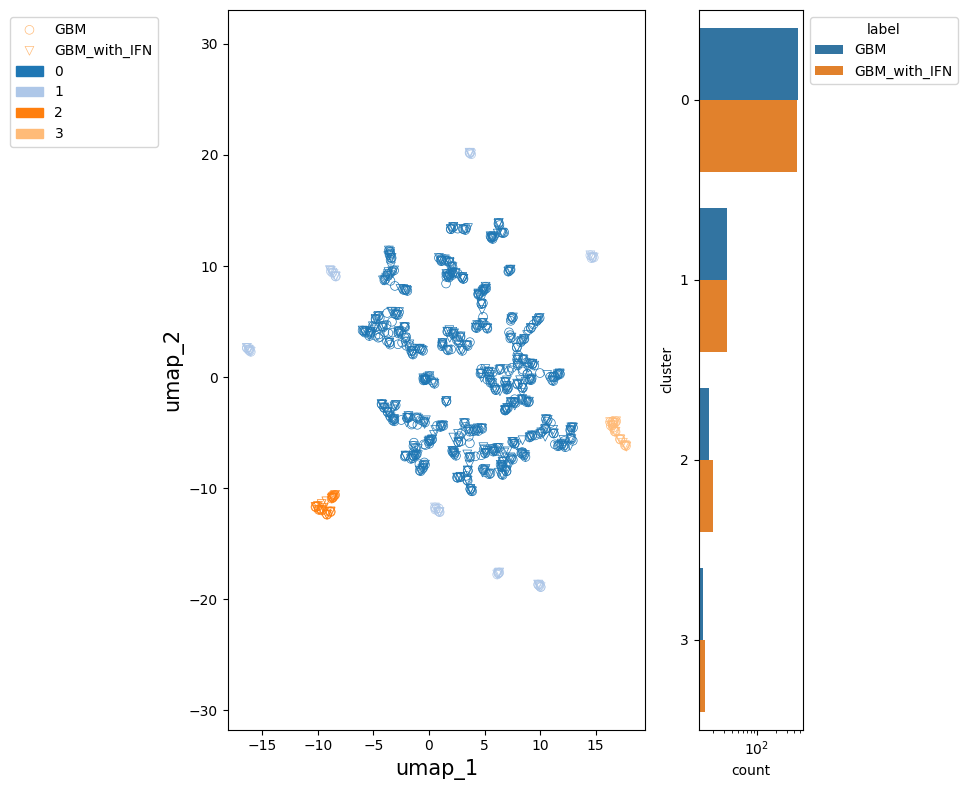

In [38]:
ha.plot_umap(peptide_clustering, clustered=True, label_col='label', countplot_log_scale=True)


The countplot on the right of the above plot suggests that the composition of each cluster is fairly similar, although there appear to be some slight differences. In order to visualize what may be causing these differences, we can create a logo plot of each group for each cluster:

3
0
1
2


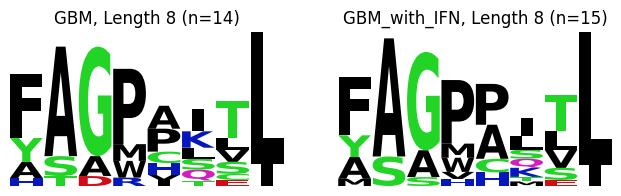

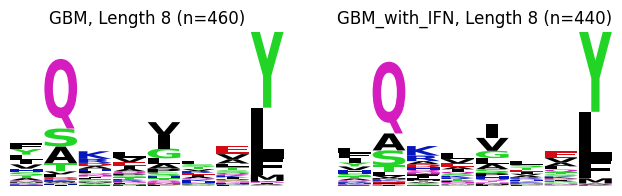

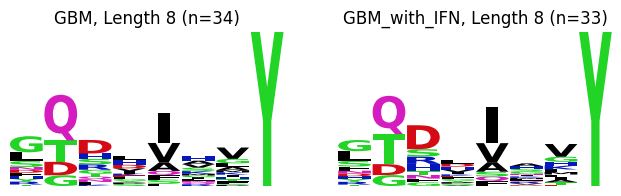

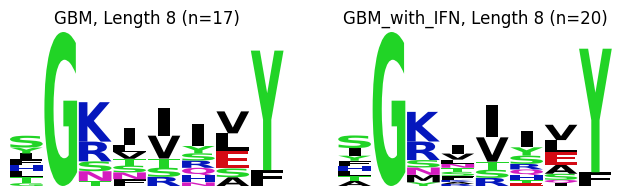

In [39]:
for clus in peptide_clustering.cluster.unique():
    print(clus)
    ha.plot_logo(peptide_clustering.loc[peptide_clustering.cluster == clus], length=8, label_col='label')


### Peptide binding prediction <a name="predict"></a>

Finally, the HLAthena package can generate predictions for a set of peptides. We will illustrate how scores can be generated on our demo A0101 9-mer model. 

Note: This functionality is in development. Updated pan-allele and pan-length models will be added. Cleavability and expression input feature support will also be provided.

In [40]:
GBM_peptide_dataset.subset_data(peplens=9, reset_index=True)

model_path = '../models/NN-time2022-12-16_10-fold0.pt'

ha.predict(model_path, GBM_peptide_dataset.get_peptides())

peptide_data.feature_dimensions 180


,seq,score
0,AAAAAQSVY,1.7319332982879132e-05
1,AAAAPRAVA,0.00040368433110415936
2,AAAAPSPVM,0.000597730337176472
3,AAADASPSL,0.8297680616378784
4,AAADVLEAL,0.9996784925460815
...,...,...
5662,YVDQQFEQY,0.005404259543865919
5663,YVEKFALNY,1.3267753274703864e-05
5664,YVIDPIKGL,0.8999943733215332
5665,YVNLPTIAL,0.092209093272686
